<a href="https://colab.research.google.com/github/danielbauer1979/FI830/blob/main/HW4_Simulation_%26_Delta_Hedge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import the necessary packages
import pandas as pd
import scipy.stats as st
import numpy as np
import matplotlib.pyplot as plt

# Simulation of a GBM path
Simulate the path a Geometric Borwnian motion:
$$
dS_t=S_t(\mu\ dt+\sigma\ dW_t),\ S_0>0,
$$
with $\mu=8\%,\ \sigma=16\%,\ S_0=5062$ over the interval $[0,1]$ with $n=250$ time steps using


*   the Euler scheme
*   the "exact" simulation method.



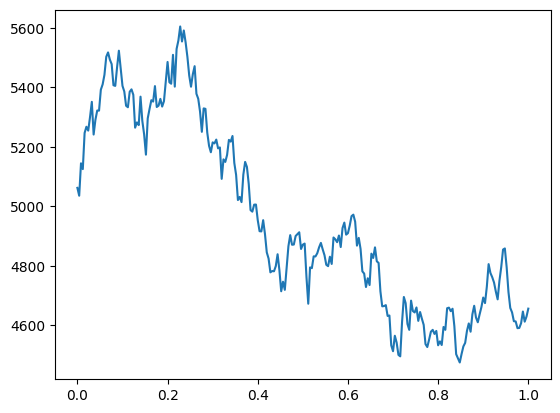

In [ ]:
# Simulation (Euler)

mu = 0.08; sigma = 0.16; S0 = 5062; n = 250; T = 1  #Parameters

timegrid = np.arange(0,T+T/n,T/n)
#timegrid = np.append(timegrid, 1)

stockpath = [S0]
for i in range(1,n+1):
  Z = np.random.normal(0,1,1)
  stockpath = np.append(stockpath, stockpath[i-1]+stockpath[i-1]*mu*T/n+stockpath[i-1]*sigma*np.sqrt(T/n)*Z)

plt.plot(timegrid, stockpath)
plt.show()

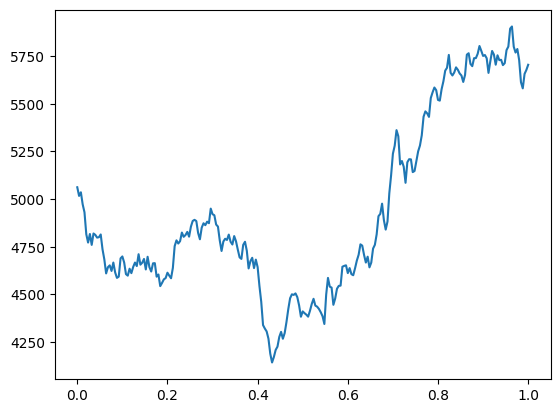

In [ ]:
# Simulation (Exact)

stockpath2 = [S0]
for i in range(1,n+1):
  Z = np.random.normal(0,1,1)
  stockpath2 = np.append(stockpath2, stockpath2[i-1]*np.exp((mu-sigma**2/2)*T/n+sigma*np.sqrt(T/n)*Z))

plt.plot(timegrid, stockpath2)

# Delta-Hedging
Assume today is 02/28/2023. The S\&P 500 index is at \$3,977.19, its volatility is 12\%, and the risk-free interest rate is 5\%. You work in an investment bank that sells a European Call option at the money (i.e.\ the strike is $K=\$3,977.19$) expiring in one year (at $t=T=1$). For simplicity,  assume that the year has 252 (trading-)days 02/28/2024.

In [ ]:
# Upload dataset (don't need this if you are using jupyter notebook in anaconda)
from google.colab import files
uploaded = files.upload()
# You might want to upload a csv file as it's easier to import

Saving FI830_HW4Series-2.xlsx to FI830_HW4Series-2 (2).xlsx


In [ ]:
# Import dataset
SP_data = pd.read_excel("FI830_HW4Series-2.xlsx") # could also use pd.read_excel() but might need the io package and additional functions
# If you are using anaconda, then pd.read_excel('filename.xlsx',sheet_name='sheetname') would work.

# Convert pandas dataframe to arrays
real = np.flip(SP_data['Actual'].values)
fict1 = np.flip(SP_data['Fict. 1'].values)
fict2 = np.flip(SP_data['Fict. 2'].values)
fict3 = np.flip(SP_data['Fict. 3'].values)
#time = SP_data['t'].values
time = np.linspace(0,1,num=253,endpoint=True)

# Parameters
S0 = 3977.19; K = 3977.19; T = 1; sigma = 0.12; r = 0.05; dt = 1/252

In [ ]:
# Calculates the put value and delta
def BS_DeltaPut(S0, K, T, sigma, r):
  N = st.norm.cdf
  d1 = (np.log(S0/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
  d2 = d1 - sigma* np.sqrt(T)
  #print(d1,d2)
  return(K*np.exp(-r*T)*N(-d2) - S0*N(-d1), N(d1)-1)

print("The Put option price at time zero by the BS formula is $%.2f" %BS_DeltaPut(S0, K, T, sigma, r)[0])

The Put option price at time zero by the BS formula is $104.52


In [ ]:
# Calculates the put value and delta
def BS_DeltaCall(S0, K, T, sigma, r):
  N = st.norm.cdf
  d1 = (np.log(S0/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
  d2 = d1 - sigma* np.sqrt(T)
  #print(d1,d2)
  return S0*N(d1)-np.exp(-r*T)*K*N(d2), N(d1)

print("The Call option price at time zero by the BS formula is $%.2f" %BS_DeltaCall(S0, K, T, sigma, r)[0])

The Call option price at time zero by the BS formula is $298.49


In [ ]:
def Delta_Hedge(St,K,dt,sigma,r,n):
  # Initial values
  C0 = BS_DeltaCall(S0,K,T,sigma,r)[0]
  D0 = BS_DeltaCall(S0,K,T,sigma,r)[1]
  Fund = [C0]
  Delta = [D0]
  Bank = [C0-D0*S0]

  for i in range(1,int(T/dt)):
    Fund = np.append(Fund,Bank[i-1]*np.exp(r*dt)+Delta[i-1]*St[i-1]) # update fund, St starts with S_t1
    if i % n == 0:
      Delta = np.append(Delta,BS_DeltaCall(St[i-1],K,T-time[i],sigma,r)[1]) # update delta at the rebalance day
    else:
      Delta = np.append(Delta,Delta[i-1]) # no updates at non-rebalancing days
    Bank = np.append(Bank,Fund[i]-Delta[i]*St[i-1]) # update bank account
  Fund_T = Bank[-1]*np.exp(r*dt)+Delta[-1]*St[-1] # Fund value at the terminal period
  return(Fund_T-max(St[-1]-K,0),Delta) # returns the difference between the values of the replicating portfolio and the put option at time T


In [ ]:
results = pd.DataFrame({'Rebalance freq n':[1,2,4],
                        'Actual':[Delta_Hedge(real,K,dt,sigma,r,1),
                                   Delta_Hedge(real,K,dt,sigma,r,2),
                                   Delta_Hedge(real,K,dt,sigma,r,4)],
                        'Fict. 1':[Delta_Hedge(fict1,K,dt,sigma,r,1),
                                 Delta_Hedge(fict1,K,dt,sigma,r,2),
                                 Delta_Hedge(fict1,K,dt,sigma,r,4)],
                        'Fict. 2':[Delta_Hedge(fict2,K,dt,sigma,r,1),
                                 Delta_Hedge(fict2,K,dt,sigma,r,2),
                                 Delta_Hedge(fict2,K,dt,sigma,r,4)],
                        'Fict. 3':[Delta_Hedge(fict3,K,dt,sigma,r,1),
                                 Delta_Hedge(fict3,K,dt,sigma,r,2),
                                 Delta_Hedge(fict3,K,dt,sigma,r,4)]})

results

,Rebalance freq n,Actual,Fict. 1,Fict. 2,Fict. 3
0,1,-13.311940,18.013463,-0.287046,-104.656694
1,2,-11.202964,32.415849,-1.088648,-125.688513
2,4,-19.255290,39.013956,-6.365248,-92.884698


In [ ]:
# S0=K=3970.15, dt=1/251
S0 = 3970.15; K = 3970.15; dt = 1/251
time = np.linspace(0,1,num=252,endpoint=True)
def Delta_Hedge(St,K,dt,sigma,r,n):
  # Initial values
  C0 = BS_DeltaCall(S0,K,T,sigma,r)[0]
  D0 = BS_DeltaCall(S0,K,T,sigma,r)[1]
  Fund = [C0]
  Delta = [D0]
  Bank = [C0-D0*S0]

  for i in range(1,int(T/dt)):
    Fund = np.append(Fund,Bank[i-1]*np.exp(r*dt)+Delta[i-1]*St[i]) # update fund, St now starts with S0
    if i % n == 0:
      Delta = np.append(Delta,BS_DeltaCall(St[i],K,T-time[i],sigma,r)[1]) # update delta at the rebalance day
    else:
      Delta = np.append(Delta,Delta[i-1]) # no updates at non-rebalancing days
    Bank = np.append(Bank,Fund[i]-Delta[i]*St[i]) # update bank account
  Fund_T = Bank[int(T/dt)-1]*np.exp(r*dt)+Delta[int(T/dt)-1]*St[int(T/dt)] # Fund value at the terminal period
  return(Fund_T-max(St[int(T/dt)]-K,0)) # returns the difference between the values of the replicating portfolio and the put option at time T

rebal_freq = [1,2,4]
results = pd.DataFrame({'Rebalance freq n':rebal_freq,
                        'Actual':[Delta_Hedge(real,K,dt,sigma,r,n) for n in rebal_freq],
                        'Fict. 1':[Delta_Hedge(fict1,K,dt,sigma,r,n) for n in rebal_freq],
                        'Fict. 2':[Delta_Hedge(fict2,K,dt,sigma,r,n) for n in rebal_freq],
                        'Fict. 3':[Delta_Hedge(fict3,K,dt,sigma,r,n) for n in rebal_freq]})

results

,Rebalance freq n,Actual,Fict. 1,Fict. 2,Fict. 3
0,1,-13.286897,18.385468,-0.570180,-105.656800
1,2,-24.151242,34.978741,-4.721298,-118.094768
2,4,-38.699510,23.303927,-6.992612,-120.373565
